In [8]:
%pip install 'numpy<2', torch scikit-learn seaborn matplotlib pandas


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn

# 0: redeclare the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim=4, hidden_dim=4, layers_number=1, char_to_idx={}, idx_to_char={}):
        super().__init__()
        vocab_size = len(char_to_idx.keys())
        self.char_to_idx = char_to_idx
        self.idx_to_char = idx_to_char
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layers_number, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    # The forward function is the one getting called everytime
    # the model created by an instance of this class is called
    # model(x, hidden) == model.forward(x, hidden)
    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

# 1: load the model from the previous chapter
locale = "cy_GB" # Change this variable if you want to inspect another language you trained
model = torch.load(f'lstm_model-{locale}.pth')
torch.set_grad_enabled(False)

# 2: extract the embedding layer and its associated characters
chars = [n if n != "\n" else "\\n" for n in model.idx_to_char.values()]
embedding = model.embedding.weight.numpy()

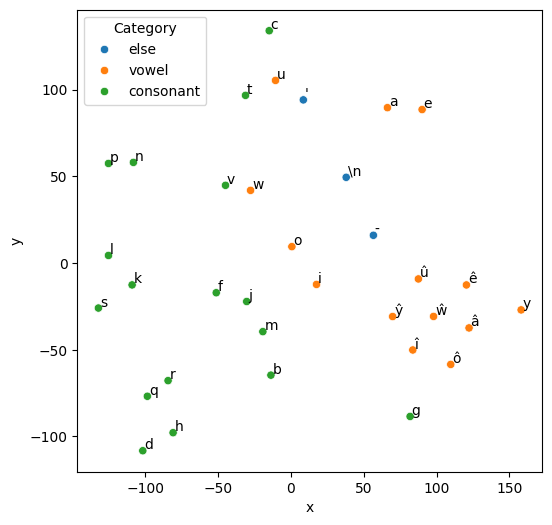

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 3 use scikit learn to do TSNE dimensionality reduction
X = np.array(embedding)
reduced_embedding = PCA(n_components=2).fit_transform(TSNE(n_components=2, perplexity=6).fit_transform(X))

df = pd.DataFrame(reduced_embedding, columns=["x", "y"])

df["chars"] = chars
df["Category"] = ["vowel" if c in "aäàâéèëêeiïîoöôuùüûœæywŷŵ" else "else" if (c == "\\n" or c in "'- ") else "consonant" for c in chars]

plt.figure(figsize=(6, 6))
sns.scatterplot(x="x", y="y", data=df, hue="Category")

for i in range(len(chars)):
    plt.annotate(df["chars"][i], (df["x"][i]+1, df["y"][i]+1))

plt.show()

In [17]:
import json

locale = "fr"
lemmas_file_path = f"lemmae.json"
pseudo_lemmas_file_path =  f"pseudo-lemmae.json"

try:
    with open(lemmas_file_path) as f:
        content = f.read()
        if not content.strip():
            raise ValueError("The JSON file is empty.")
        lemmas = json.loads(content)
except FileNotFoundError:
    print(f"Error: File not found at {lemmas_file_path}")
    lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {lemmas_file_path}")

try:
    with open(pseudo_lemmas_file_path) as f2:
        content2 = f2.read()
        if not content2.strip():
            raise ValueError("The JSON file is empty.")
        pseudo_lemmas = json.loads(content2)
except FileNotFoundError:
    print(f"Error: File not found at {pseudo_lemmas_file_path}")
    pseudo_lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    pseudo_lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {file_path}")

print(f"{len(lemmas)} items loaded from {lemmas_file_path}:\n" + "\n".join(lemmas[:10]))
print(f"{len(pseudo_lemmas)} items loaded from {pseudo_lemmas_file_path}:\n" + "\n".join(pseudo_lemmas[:10]))


10722 items loaded from lemmae.json:
'chi
'dag
'ddchi
'sti
aaron
ab
abad
abadaeth
abades
aball
10000 items loaded from pseudo-lemmae.json:
'ddo
'frifeddgar
'nlwndod
'wchram
a'do
a-lysnu
abadeiddwrnad
abadeipwg
abadell
abaeth


In [18]:
lemmas_str = "".join(lemmas)
pseudo_lemmas_str = "".join(pseudo_lemmas)
print(len(lemmas_str)/len(lemmas))
print(len(pseudo_lemmas_str)/len(pseudo_lemmas))

7.051949263197165
7.6266


    Lemmas Lengths  Pseudo-Lemmas Lengths
0         0.000000                 0.0000
1         0.002425                 0.0000
2         0.007461                 0.0019
3         0.040104                 0.0100
4         0.092334                 0.0412
5         0.136355                 0.1067
6         0.167413                 0.1708
7         0.164428                 0.1917
8         0.133091                 0.1676
9         0.100354                 0.1254
10        0.068644                 0.0791
11        0.040104                 0.0513
12        0.024342                 0.0291
13        0.012031                 0.0125
14        0.005316                 0.0061
15        0.003078                 0.0023
16        0.001492                 0.0026
17        0.000373                 0.0010
18        0.000280                 0.0005
19        0.000093                 0.0001
20        0.000187                 0.0001
21        0.000000                 0.0000
22        0.000000                

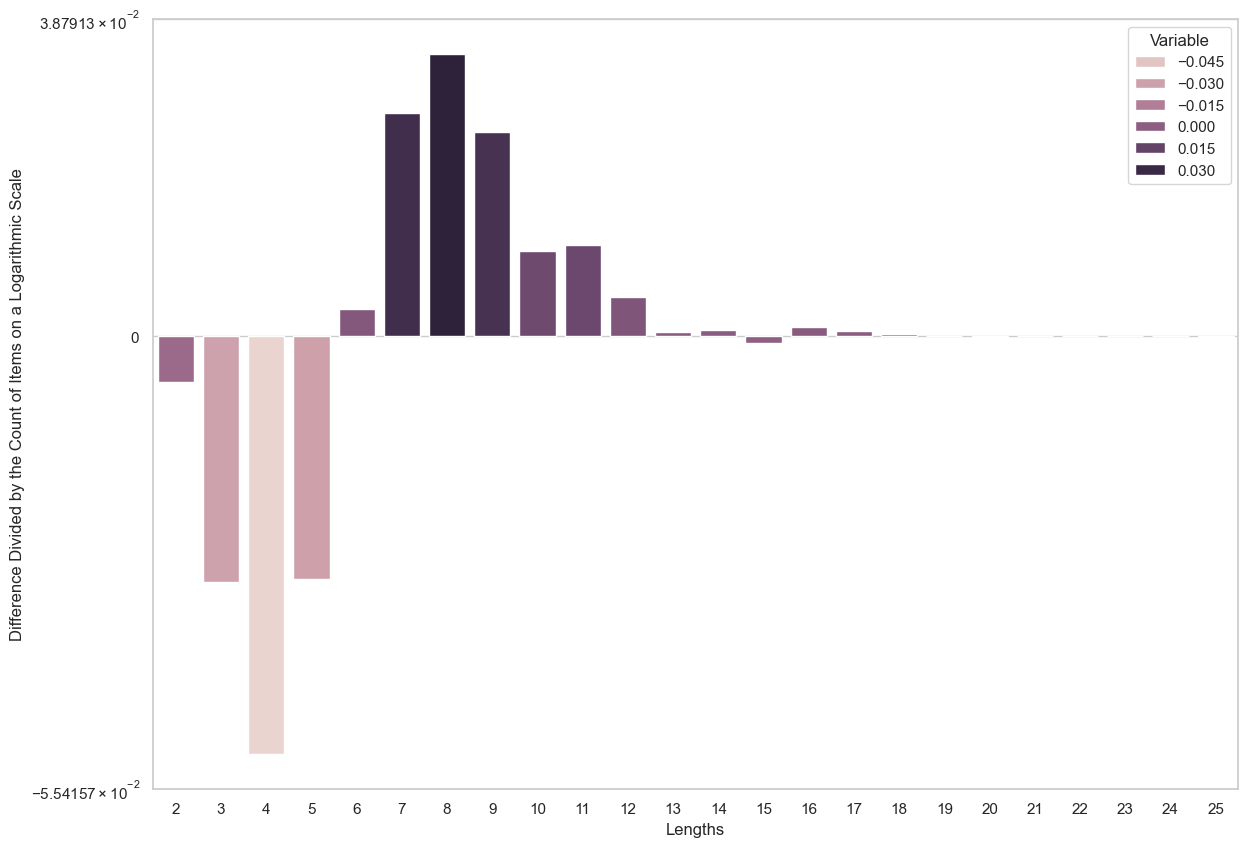

rhyddfryd-derbynlles


In [19]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

lemmas_counter = dict(Counter([len(l) for l in lemmas]))
pseudo_lemmas_counter = dict(Counter([len(l) for l in pseudo_lemmas]))
data = []
for i in range(max([i for i in lemmas_counter.keys()] + [i for i in pseudo_lemmas_counter.keys()]) + 1):
    data.append({
        "Lemmas Lengths": lemmas_counter[i]/len(lemmas) if i in lemmas_counter else 0,
        "Pseudo-Lemmas Lengths": pseudo_lemmas_counter[i]/len(pseudo_lemmas) if i in pseudo_lemmas_counter else 0
    })


lengths_df = pd.DataFrame(data)
print(lengths_df)
lengths_df["Length Difference"] = (lengths_df["Pseudo-Lemmas Lengths"] - lengths_df["Lemmas Lengths"])

lengths_df.index.name = 'Lengths'
lengths_df = lengths_df.drop([0, 1])

plt.figure(figsize=(14, 10))
sns.set_style('whitegrid')


bar_plot = sns.barplot(
    x='Lengths',
    y="Length Difference",
    hue="Length Difference",
    data=lengths_df
)
plt.yscale('symlog')

# plt.title('Comparison of the Lengths of Types and Pseudo-Words', fontsize=16)
plt.xlabel('Lengths', fontsize=12)
plt.ylabel('Difference Divided by the Count of Items on a Logarithmic Scale', fontsize=12)
plt.legend(title='Variable')
plt.show()

print(max(pseudo_lemmas, key=len))

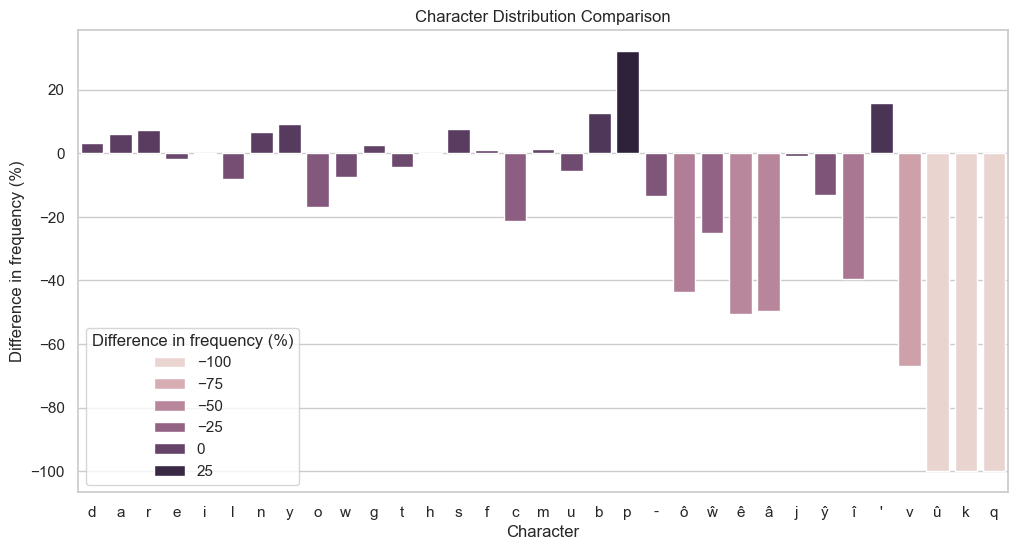

33

In [20]:
cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

chars = set(lemmas_str + pseudo_lemmas_str)
counter_lem = Counter(lemmas_str)
counter_psd = Counter(pseudo_lemmas_str)

data = []
for char in chars:
        freq_lemmas = (counter_lem.get(char, 0) / len(lemmas_str)) * 100 if lemmas_str else 0
        freq_pseudo_lemmas = (counter_psd.get(char, 0) / len(pseudo_lemmas_str)) * 100 if pseudo_lemmas_str else 0
        data.append({'Character': char, "lemmas": freq_lemmas, "pseudo_lemmas": freq_pseudo_lemmas})


df = pd.DataFrame(data)
df['avg'] = (df["lemmas"] + df["pseudo_lemmas"]) / 2
df['Difference in frequency (%)'] = (df["lemmas"] - df["pseudo_lemmas"]) * -100 / df["lemmas"]
df = df.sort_values('avg', ascending=False).drop('avg', axis=1)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Difference in frequency (%)', hue='Difference in frequency (%)', data=df)
plt.title('Character Distribution Comparison')
plt.show()
len(chars)

First characters are the same: False 30
dict_keys(["'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'y', 'ô', 'ŷ'])
["'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'w', 'y', 'â', 'ê', 'î', 'ô', 'û', 'ŵ', 'ŷ']
   Character    lemmas  pseudo_lemmas  Difference in frequency (%)
11         c  2.355477       1.833058                   -22.178918
20         a  1.510362       1.644245                     8.864290
4          d  1.137401       1.254819                    10.323365
3          p  0.954888       1.353159                    41.708700
27         g  1.212786       0.837857                   -30.914718
8          t  0.964145       0.875882                    -9.154599
26         b  0.821309       0.902106                     9.837553
10         s  0.765762       0.837857                     9.414860
25         m  0.789568       0.620198                   -21.450971
0      

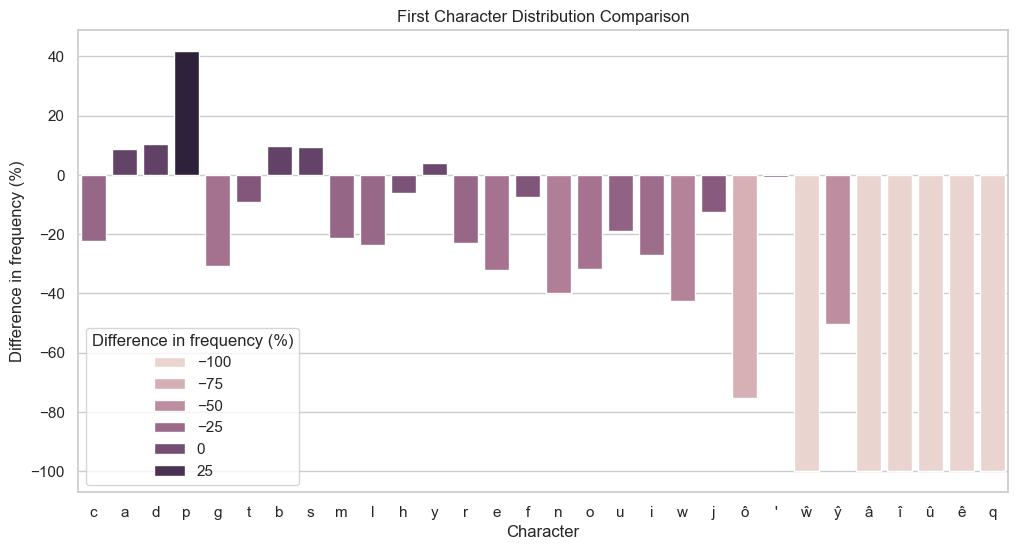

Average difference: -33.03%


In [21]:
cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

counter_lem = Counter("".join([i[0] for i in lemmas]))
counter_psd = Counter("".join([i[0] for i in pseudo_lemmas]))
chars = set("".join([i[0] for i in lemmas] + [i[0] for i in pseudo_lemmas]))
print("First characters are the same:", counter_psd.keys() == counter_lem.keys(), f"{len(chars)}")
a = counter_psd.keys()
print(a)
b = list(counter_lem.keys())
print(b)

data = []
for char in chars:
        freq_lemmas = (counter_lem.get(char, 0) / len(lemmas_str)) * 100 if lemmas_str else 0
        freq_pseudo_lemmas = (counter_psd.get(char, 0) / len(pseudo_lemmas_str)) * 100 if pseudo_lemmas_str else 0
        data.append({'Character': char, "lemmas": freq_lemmas, "pseudo_lemmas": freq_pseudo_lemmas})


df = pd.DataFrame(data)
df['avg'] = (df["lemmas"] + df["pseudo_lemmas"]) / 2
df['Difference in frequency (%)'] = (df["lemmas"] - df["pseudo_lemmas"]) * -100 / df["lemmas"]
df = df.sort_values('avg', ascending=False).drop('avg', axis=1)
average_difference = df["Difference in frequency (%)"].sum() / len(chars)

print(df)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Difference in frequency (%)', hue='Difference in frequency (%)', data=df)
plt.title('First Character Distribution Comparison')
plt.show()
print(f"Average difference: {average_difference:.2f}%")

In [22]:
file = {
    "version": 2,
    "keys": [{"w": l, "r": 200} for l in lemmas],
    "distractors": [{"w": l, "r": 200} for l in pseudo_lemmas],
}

# Define the output file path
output_file_path = f"items.json"

# Write the lemmas list to the JSON file
with open(output_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(file, outfile, ensure_ascii=False, indent=0)
